# Question 2 - Part 2: Analyse KSI Dataset against Jays Schedule
#### Attempt to discover if there exists a correlation between Jays games letting out and an increase in vehicular accidents in a 5km radius around the Rogers Centre


In [1]:
# Question 2
# analyzing the impact of major sporting events of traffic accidents

!pip install haversine

import pandas as pd
import numpy as np

from haversine import haversine

from string import Template
from dateutil import parser
from dateutil import relativedelta

from datetime import datetime
from datetime import timedelta

TPS_KSI_CSV_PATH = "https://opendata.arcgis.com/datasets/9f05c21dea4c40458264cb3f1e2362b8_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D&session=1523497917.1562243815"
BLUE_JAYS_CSV_PATH = "https://gist.githubusercontent.com/kcarmonamurphy/fab52a15b01f07c36f1b8040a3d2cf5c/raw/54fc5d310d3090bce0ea3e6f264d782941d18a7e/toronto_blue_jays_home_game_scheduled_start_and_finish_times_2008_to_2018.csv"

ROGERS_CENTRE_LATITUDE = 43.638164114
ROGERS_CENTRE_LONGITUDE = -79.386831786


In [2]:
# read in data from TPS KSI dataset
ksi_data = pd.read_csv(TPS_KSI_CSV_PATH)

# read in blue jays data and coerce game start and game finish fields to datetime
blue_jays_data = pd.read_csv(BLUE_JAYS_CSV_PATH)
blue_jays_data.game_finish = pd.to_datetime(blue_jays_data.game_finish)
blue_jays_data.game_start = pd.to_datetime(blue_jays_data.game_start)

In [3]:
attendance_cuts = ["low", "medium low", "medium high", "high", "very high"]

blue_jays_data['attendance_cut'] = pd.qcut(blue_jays_data['attendance'], q=len(attendance_cuts), labels=attendance_cuts)
blue_jays_dict = {key: blue_jays_data.loc[value] for key, value in blue_jays_data.groupby("attendance_cut").groups.items()}

In [4]:
def get_distance_from_rc(row):
  accident_location = (row['LATITUDE'], row['LONGITUDE'])
  rogers_centre_location = (ROGERS_CENTRE_LATITUDE, ROGERS_CENTRE_LONGITUDE)
  
  distance = haversine(accident_location, rogers_centre_location)
  return distance

In [5]:
def create_timestamp(row):
  parsed_date = parser.parse(row['DATE'])
  time = row['TIME']
  hour = time // 100
  minute = time % 100
  
  timestamp = datetime(parsed_date.year, parsed_date.month, parsed_date.day, hour, minute)
  return timestamp

In [6]:
def restrict_ksi_based_on_radius(ksi_data, radius):
  ksi_data['distance_from_rc'] = ksi_data.apply(get_distance_from_rc, axis=1)
  ksi_data['timestamp'] = ksi_data.apply(create_timestamp, axis=1)
  ksi_cleaned = ksi_data.drop(['X', 'Y', 'DATE', 'TIME', 'Hour', 'YEAR'], axis=1)

  restricted_ksi = ksi_cleaned[ksi_cleaned['distance_from_rc'] < radius]
  return restricted_ksi

In [7]:
def restrict_ksi_based_on_time_lag(ksi_data, event_end_series, time_lag):
  
  # create identity Series based on index values of ksi_data
  filter_arr = pd.Series(False, index=ksi_data.index)

  for game_finish in event_end_series:
    analysis_end = game_finish + timedelta(hours=time_lag)

    # for the period after every game end, see if there are any accidents in ksi set
    filter_arr |= ksi_data.timestamp.between(game_finish, analysis_end)
    
  restricted_ksi = ksi_data[filter_arr]
  return restricted_ksi

In [8]:
def restrict_ksi(ksi_data, bj_attendance_category, radius, time_lag):
  radius_restricted_ksi = restrict_ksi_based_on_radius(ksi_data, radius)
  radius_and_time_lag_restricted_ksi = restrict_ksi_based_on_time_lag(
      radius_restricted_ksi,
      blue_jays_dict[bj_attendance_category].game_finish,
      time_lag
  )
  return radius_and_time_lag_restricted_ksi

# Begin the analysis

In [9]:
def graph_accidents_by_attendance_quintiles(radius, time_lag):
  # this operation will take a while!
  dataset = {attendance_level: restrict_ksi(ksi_data, attendance_level, radius, time_lag) for attendance_level in attendance_cuts}

  num_accidents = {k: len(v) for (k,v) in dataset.items()}
  num_accidents_df = pd.DataFrame(list(num_accidents.items()), columns=['Attendance', '# of Accidents'])
  num_accidents_df.set_index('Attendance', inplace=True)

  # plot the graph
  num_accidents_df.plot.bar(title="Accidents by Attendance Quintile")

### Graph 1 (time lag: 5 hours, radius: 5 kilometres)

Shows that on games with high attendance, there was a higher number of accidents

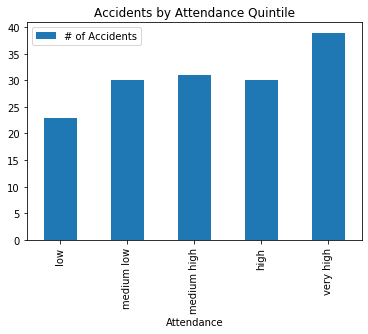

In [12]:
TIME_LAG_IN_HOURS = 5
RADIUS = 5

# this will take a while to execute
graph_accidents_by_attendance_quintiles(RADIUS, TIME_LAG_IN_HOURS)

### Graph 2 (time lag: 5 hours, radius: 3 kilometres)

Shows that on games with medium attendance, there was a higher number of accidents

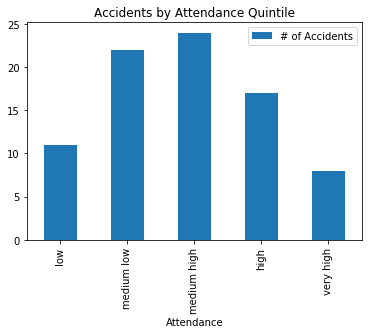

In [11]:
TIME_LAG_IN_HOURS = 5
RADIUS = 3

graph_accidents_by_attendance_quintiles(RADIUS, TIME_LAG_IN_HOURS)

### Graph 3 (time lag: 2 hours, radius: 3 kilometres)

Shows that overall, similar levels of accidents despite attendance

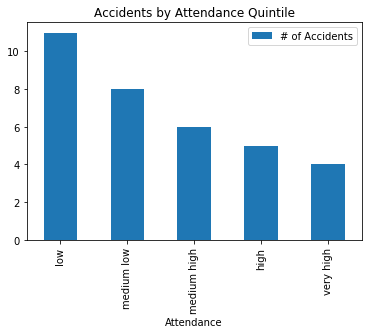

In [13]:
TIME_LAG_IN_HOURS = 2
RADIUS = 3

graph_accidents_by_attendance_quintiles(RADIUS, TIME_LAG_IN_HOURS)